In [3]:
import pandas as pd
import numpy as np

###import pybrain as pb
from pybrain.tools.shortcuts import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.datasets import SupervisedDataSet
from pybrain.structure import SigmoidLayer
from pybrain.structure import LinearLayer
from pybrain.structure import SoftmaxLayer

from sklearn import linear_model
from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

import pickle
import json

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz

pd.set_option('display.precision', 3);
%matplotlib inline

import numpy as np
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
import json

dictModel_linear   = dict()
dictModel_tree     = dict()
dictModel_neuroNet2 = dict()
dictModel_neuroNet12 = dict()
dictModel_base     = dict()

In [14]:
data = pd.read_csv('ccpp.csv', # путь к файлу,
                   sep=';', # разделитель данных в файле
                   decimal=",",# дробная часть отделяется запятой
                   header=0) # номер строки с заголовками
data.columns = ([u'Temperature', u'Vacuum', u'Pressure',u'Humidity', u'EnergyOutput'])

In [15]:
features = [u'Temperature', u'Vacuum']
target = [u'EnergyOutput']

In [10]:
data.shape

(9568, 5)

In [16]:
dataOrigin = data

## 1.1. Проверка признаков на выбросы

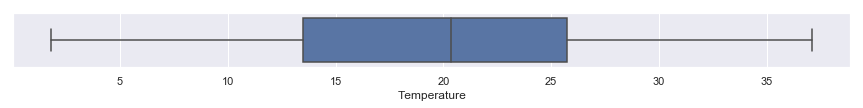

In [18]:
plt.figure(figsize=(15,1))
sns.boxplot(dataOrigin['Temperature'])

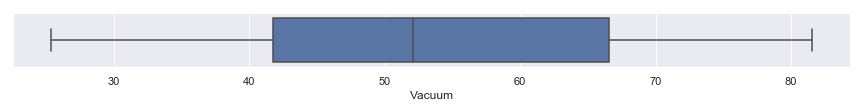

In [20]:
plt.figure(figsize=(15,1))
sns.boxplot(dataOrigin['Vacuum'])

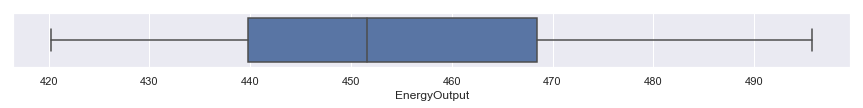

In [22]:
plt.figure(figsize=(15,1))
sns.boxplot(dataOrigin['EnergyOutput'])

## 1.2. Нормализация данных

### 1.2.2. Нормализация количественных признаков

In [24]:
from sklearn import preprocessing

testArr = np.array(  [-2,1,2,4,4,4,4,4,5,5,5,6,7,7,9,20] )

print "Исходный ", testArr
print  testArr.mean(), "Cреднее (mean)"
print  testArr.std(), "Среднеквадратическое отклонение (standard_deviation)"
print  testArr.std()**2, "Дисперсия (variance)"

# Нормализация
testArr_Norm = preprocessing.Normalizer(norm='l2').transform( [testArr] )
print "\nНормализованный\n", testArr_Norm
print testArr_Norm.mean(axis=1), "Cреднее (mean)"
print testArr_Norm.std(axis=1)**2, "Дисперсия (variance)"

print "\n--- Проверка денормализации \n", (testArr_Norm * (testArr.max() - testArr.min() )) + testArr.min()

Исходный  [-2  1  2  4  4  4  4  4  5  5  5  6  7  7  9 20]
5.3125 Cреднее (mean)
4.523808544799393 Среднеквадратическое отклонение (standard_deviation)
20.464843750000004 Дисперсия (variance)

Нормализованный
[[-0.07165744  0.03582872  0.07165744  0.14331487  0.14331487  0.14331487
   0.14331487  0.14331487  0.17914359  0.17914359  0.17914359  0.21497231
   0.25080103  0.25080103  0.32245846  0.71657436]]
[0.19034007] Cреднее (mean)
[0.02627066] Дисперсия (variance)

--- Проверка денормализации 
[[-3.5764636  -1.2117682  -0.4235364   1.1529272   1.1529272   1.1529272
   1.1529272   1.1529272   1.941159    1.941159    1.941159    2.7293908
   3.5176226   3.5176226   5.0940862  13.76463601]]


## 1.2.2.1. Нормализация исходных данных

In [26]:
# Разделение столбцов с числовыми и категориальными значениями 
digital_colums = list()
cat_colums     = list()

# для каждого названия столбца
for col_name in data.columns:
    
    # если тип данных столбца не равен числовому
    if (data[col_name].dtype != 'object'):
        # добавить в список числовых
        digital_colums.append(col_name)
        
    else:
        # иначе добавить в список категориальных
        cat_colums.append(col_name)
        
print digital_colums
print cat_colums

[u'Temperature', u'Vacuum', u'Pressure', u'Humidity', u'EnergyOutput']
[]


In [28]:
dataNumeric = data[digital_colums] # таблица только числовых признаков
dataNumeric.shape

(9568, 5)

In [31]:
dictScaler = dict(); # словарь стандартизирующих шкал
dictScaledValue = dict(); # словарь стандартизированных значений
'''
# для каждого имени чисолового признака
# - создать шкалу, 
# - привести значеник [0.0, 1.0], 
# - заменить значения на приведенные в таблице dataNumeric
'''
for col_name in digital_colums:
    print ""
    print col_name
    
    # создать шкалу  MinMaxScaler(feature_range=(0, 1))
    dictScaler[col_name] = MinMaxScaler(feature_range=(0, 1))
    
    # для очередного имени признака провести настройку шкалы на основе значений исходной таблицы 
    column_scaler = dictScaler[col_name]
    column_scaler.fit( dataNumeric [[col_name]] )

    print  "data_min_    = ",  (column_scaler.data_min_ )
    print  "data_max_    = ",  (column_scaler.data_max_ )
    print  "min_ = ",          (column_scaler.min_)   # min - X.min(axis=0) * self.scale_ 
    print  "scale_ = ",        (column_scaler.scale_) # (max - min) / (X.max(axis=0) - X.min(axis=0))
    print  "data_range_  = ",  (column_scaler.data_range_ )
    
    # для очередного имени признака добавить в словарь приведенные значения к диапазону [0.0, 1.0]
    dictScaledValue[col_name] = column_scaler.transform( dataNumeric[[col_name]] )
    
    # заменить значения на приведенные в таблице dataNumeric
    dataNumeric.loc[:, col_name] = dictScaledValue[col_name]


Temperature
data_min_    =  [0.]
data_max_    =  [1.]
min_ =  [0.]
scale_ =  [1.]
data_range_  =  [1.]

Vacuum
data_min_    =  [0.]
data_max_    =  [1.]
min_ =  [0.]
scale_ =  [1.]
data_range_  =  [1.]

Pressure
data_min_    =  [0.]
data_max_    =  [1.]
min_ =  [0.]
scale_ =  [1.]
data_range_  =  [1.]

Humidity
data_min_    =  [0.]
data_max_    =  [1.]
min_ =  [0.]
scale_ =  [1.]
data_range_  =  [1.]

EnergyOutput
data_min_    =  [0.]
data_max_    =  [1.]
min_ =  [0.]
scale_ =  [1.]
data_range_  =  [1.]


Сравним описание cтандартизованных и исходных данных

In [33]:
print "# Просмотр исходной таблицы числовых значений"
data[digital_colums][:2]

# Просмотр исходной таблицы числовых значений


,Temperature,Vacuum,Pressure,Humidity,EnergyOutput
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75


In [35]:
print "# Просмотр стандартизированных числовых значений"
dataNumeric[:2]

# Просмотр стандартизированных числовых значений


,Temperature,Vacuum,Pressure,Humidity,EnergyOutput
0,0.185,0.274,0.444,0.864,0.798
1,0.618,0.590,0.458,0.652,0.338


In [37]:
data.describe()

,Temperature,Vacuum,Pressure,Humidity,EnergyOutput
count,9568.000,9568.000,9568.000,9568.000,9568.000
mean,19.651,54.306,1013.259,73.309,454.365
std,7.452,12.708,5.939,14.600,17.067
min,1.810,25.360,992.890,25.560,420.260
25%,13.510,41.740,1009.100,63.328,439.750
50%,20.345,52.080,1012.940,74.975,451.550
75%,25.720,66.540,1017.260,84.830,468.430
max,37.110,81.560,1033.300,100.160,495.760


In [39]:
dataNumeric.describe()

,Temperature,Vacuum,Pressure,Humidity,EnergyOutput
count,9568.000,9568.000,9568.000,9568.000,9568.000
mean,0.505,0.515,0.504,0.640,0.452
std,0.211,0.226,0.147,0.196,0.226
min,0.000,0.000,0.000,0.000,0.000
25%,0.331,0.291,0.401,0.506,0.258
50%,0.525,0.475,0.496,0.662,0.414
75%,0.677,0.733,0.603,0.795,0.638
max,1.000,1.000,1.000,1.000,1.000


## 1.3. Разбиение на обучающую и тестовую выборку

In [41]:
corrUnnorm  = data[digital_colums].corr() 
corrNorm    = dataNumeric[digital_colums].corr() 
print "Максимальное значение разности коэфф. корреляции = ", (corrUnnorm - corrNorm).max().max()

Максимальное значение разности коэфф. корреляции =  3.1086244689504383e-15


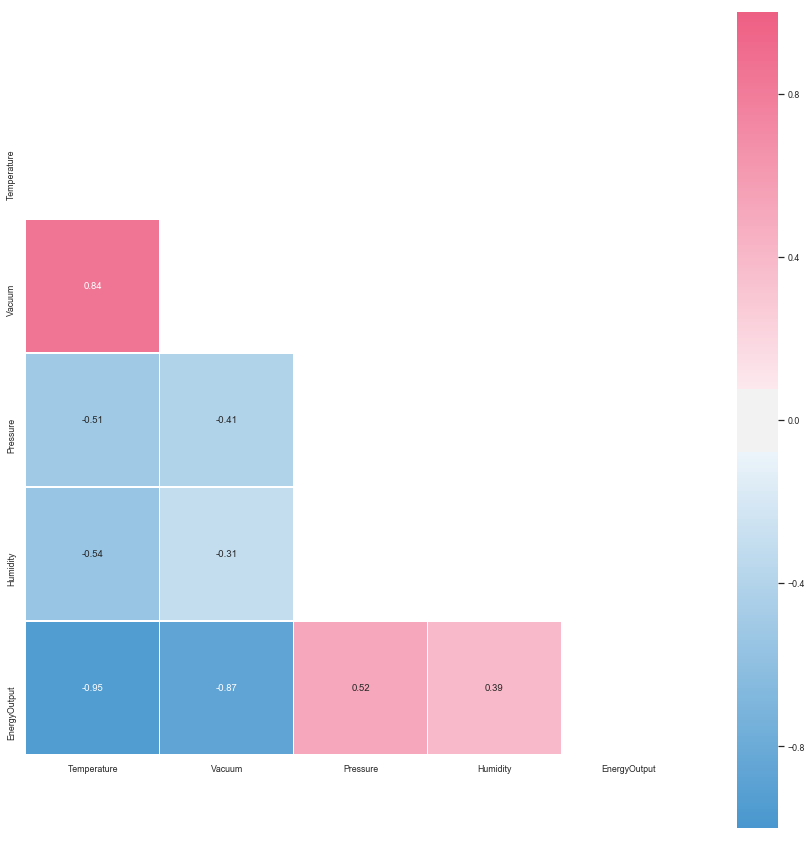

In [43]:
corrThresshold = 0.20 # пороговое значение для коэфф. корреляции 

# цветовая карта
p = sns.diverging_palette(240, # HSV тон положительного
                          0,   # HSV тон отрицательного
                          s=80, # насыщенность.
                          l=60, # яркость
                          sep=20, # ширина центральной "нечувствительной" области
                          n=6,
                          center='light',
                          as_cmap=True)

# построить "маску" для отображения только нижнего треугольника
mask = np.zeros_like(corrNorm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=0.8, style="white")

plt.figure(figsize=(15,15))

# вывод в виде тепловой карты
sns.heatmap(
   data= corrNorm[ ( corrNorm.abs()) > corrThresshold ],  # данные с сравнением абсолютного значения с пороговогым
   cmap=p,  # цветовая карта
   mask=mask,   # применить маску
   square=True, # форма ячейки - квадрат
   annot=True, # вывод значений
   fmt=".2f", # формат вывода значений
   vmin=-1, vmax=1, # граничные значения для цветовой карты 
   linewidths=.5, # расстояние между ячейками
);

In [45]:
dataNumeric[features+target].corr()

,Temperature,Vacuum,EnergyOutput
Temperature,1.000,0.844,-0.948
Vacuum,0.844,1.000,-0.870
EnergyOutput,-0.948,-0.870,1.000


In [47]:
valid_size = 0.3 # доля тестовой части в выборке
rand_seed = 8 # начальное состояние генератора случ. чисел

In [49]:
# Нормированная таблица. Только выбранные признаки
x_train, x_test, y_train, y_test =  train_test_split(
    dataNumeric[features], dataNumeric[target], # исходные данные
    test_size = valid_size, 
    random_state=rand_seed, 
    shuffle=True # перемешивание
) 
print "Кол-во элементов: \n  x_train: {}, y_train {} \n  x_test:  {}, y_test  {} \n  total x: {}, total y {} ".format  (
    len(x_train), len(y_train),
    len(x_test),  len(x_test), 
    len(x_train)+len(x_test), len(y_train)+len(x_test),
)

Кол-во элементов: 
  x_train: 6697, y_train 6697 
  x_test:  2871, y_test  2871 
  total x: 9568, total y 9568 


Сохраним проверочную части исходной таблицы со всеми признаками в отдельный файл.

In [51]:
# Исходная таблица. Все признаки
x_trainALLF, x_testALLF, y_trainALLF, y_testALLF =  train_test_split(
    data.drop(columns=target), data[target], # исходные данные
    test_size = valid_size, 
    random_state=rand_seed, 
    shuffle=True # перемешивание
) 
(pd.concat( [x_testALLF, y_testALLF], axis=1)).to_csv('./WV_test.csv', index=False )
x_testALLF[:2]

,Temperature,Vacuum,Pressure,Humidity
8722,12.64,41.49,1019.78,94.00
8479,27.08,62.91,1011.90,62.58


In [53]:
# Нормированная таблица. Все признаки
x_trainALLF_Norm, x_testALLF_Norm, y_trainALLF_Norm, y_testALLF_Norm =  train_test_split(
    dataNumeric.drop(columns=target), dataNumeric[target], # исходные данные
    test_size = valid_size, 
    random_state=rand_seed, 
    shuffle=True # перемешивание
) 
(pd.concat( [x_testALLF_Norm, y_testALLF_Norm], axis=1)).to_csv('./WVNorm_test.csv', index=False )
x_testALLF_Norm[:2]

,Temperature,Vacuum,Pressure,Humidity
8722,0.307,0.287,0.665,0.917
8479,0.716,0.668,0.470,0.496


In [55]:
x_test.head(2)

,Temperature,Vacuum
8722,0.307,0.287
8479,0.716,0.668


In [57]:
y_test.head(2)

,EnergyOutput
8722,0.643
8479,0.300


<Figure size 432x288 with 0 Axes>

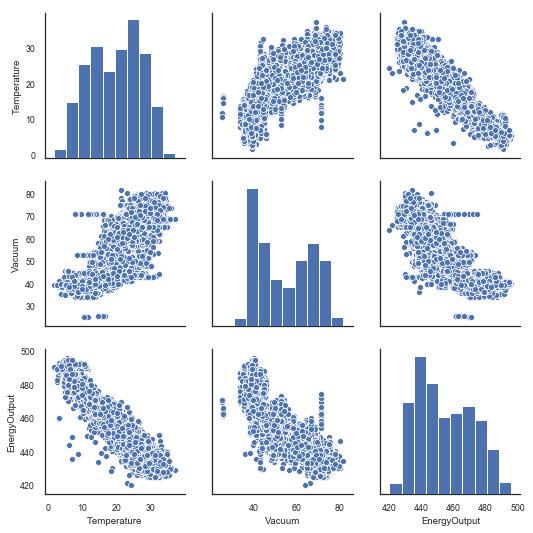

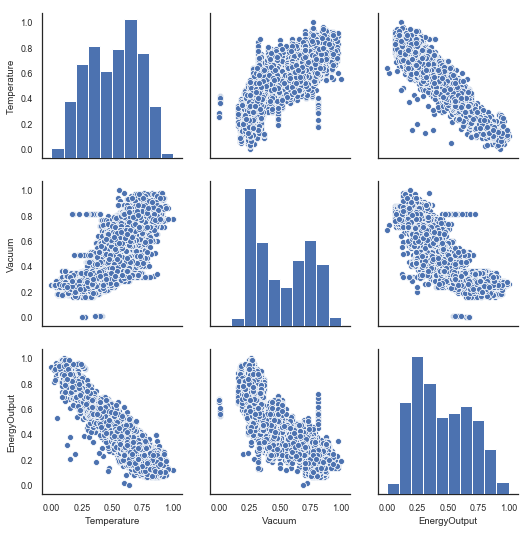

In [59]:
%config InlineBackend.figure_format = 'png' 
plt.figure()
sns.pairplot(data[features+target])
sns.pairplot(dataNumeric[features+target])

# 2. Нейронная сеть

In [61]:
from pybrain.tools.shortcuts import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.datasets import SupervisedDataSet
from pybrain.structure import SigmoidLayer
from pybrain.structure import LinearLayer
from pybrain.structure import SoftmaxLayer

## 2.1. Модель нейронной сети

In [63]:
net = buildNetwork(2, 9, 6, 1)
net.name="net_3to1_SalePrice"
current_epoch = 0 # количество проведенных итераций обучения

# просмотр информации о структуре и типе фунции активации каждого слоя
print net

net_3to1_SalePrice
   Modules:
    [<BiasUnit 'bias'>, <LinearLayer 'in'>, <SigmoidLayer 'hidden0'>, <SigmoidLayer 'hidden1'>, <LinearLayer 'out'>]
   Connections:
    [<FullConnection 'FullConnection-17': 'hidden1' -> 'out'>, <FullConnection 'FullConnection-18': 'in' -> 'hidden0'>, <FullConnection 'FullConnection-19': 'hidden0' -> 'hidden1'>, <FullConnection 'FullConnection-20': 'bias' -> 'out'>, <FullConnection 'FullConnection-21': 'bias' -> 'hidden0'>, <FullConnection 'FullConnection-22': 'bias' -> 'hidden1'>]



In [65]:
# Создать объект для хранения 2 входных и 1 выходного значения
ds = SupervisedDataSet(2, 1)

In [66]:
ds.clear()
ds.setField('input',  x_train[features]) # входные
ds.setField('target', y_train[target])   # выходные

In [67]:
if ( (len(x_train) == ds.getLength()) ):
    print "Добавление данных прошло успешно. ", ds.getLength(), "элементов."
else:
    print "Не совпадает кол-во элементов. При добавлении данных возникли проблемы."

Добавление данных прошло успешно.  6697 элементов.


In [68]:
row_num = 10
print "SupervisedDataSet ", ds.getSample(row_num)
print "x_train           ", x_train[features].iloc[row_num].values, y_train[target].iloc[row_num].values

SupervisedDataSet  [array([0.64135977, 0.76992883]), array([0.34529801])]
x_train            [0.64135977 0.76992883] [0.34529801]


In [69]:
print "SupervisedDataSet "
print ds['input'][:3]

SupervisedDataSet 
[[0.51529745 0.78505338]
 [0.24305949 0.34679715]
 [0.49036827 0.44128114]]


In [70]:
print "x_train           "
print x_train[:3]

x_train           
      Temperature  Vacuum
6630        0.515   0.785
7447        0.243   0.347
5127        0.490   0.441


In [71]:
print "SupervisedDataSet "
print ds['target'][:3]

SupervisedDataSet 
[[0.37788079]
 [0.76543046]
 [0.41364238]]


In [72]:
print "y_train           "
print y_train[:3]

y_train           
      EnergyOutput
6630         0.378
7447         0.765
5127         0.414


Обучение модели

In [73]:
trainerSellHouse = BackpropTrainer(net, dataset=ds)

In [74]:
print "Double proportional to the error:  {:>10,.6f}".format(trainerSellHouse.train() ) 
current_epoch += 1


y_pred_OnTrain = list()
# получить выходное значение на основе очередного входного вектора
for inp, tar in ds:
    y_pred_OnTrain.append( [net.activate(inp)[0]])
    
# Проверим точность модели на обучающей выборке
r2           = metrics.r2_score                   (y_train, y_pred_OnTrain)
mae_tree     = metrics.mean_absolute_error        (y_train, y_pred_OnTrain)
mse_LinRegr  = metrics.mean_squared_error         (y_train, y_pred_OnTrain) 
rmse_LinRegr = np.sqrt( mse_LinRegr )
print "MAE  {:>10,.6f} - средняя абсолютная ошибка.".format( mae_tree)
print "MSE  {:>10,.6f} - средреквадратичная ошибка.".format( mse_LinRegr )
print "RMSE {:>10,.6f} - кв. корень из средреквадратичной ошибки.".format( rmse_LinRegr )
print "R2   {:>10,.6f} - коэфф. детерминации.".format( r2 )

print ""

Double proportional to the error:    0.017497
MAE    0.097124 - средняя абсолютная ошибка.
MSE    0.014635 - средреквадратичная ошибка.
RMSE   0.120973 - кв. корень из средреквадратичной ошибки.
R2     0.713775 - коэфф. детерминации.



Проведем последовательно несколько итераций (эпох) обучения модели c расчетом метрик точности на каждой итерации.

In [75]:
## trainEpochs
R2_OnTrain = list()
R2_OnTest = list()

max_epoch =25
target_epoch = current_epoch+max_epoch

for i in range (current_epoch, target_epoch):
    print "{:>2} / {} epoch".format(i,target_epoch)
    current_epoch = i
    
    #trainerSellHouse.trainEpochs(i)
    trainerSellHouse.train()
    
    y_pred_OnTrain = list()
    for inp, tar in ds:
        y_pred_OnTrain.append( [net.activate(inp)[0]])
      
    y_pred_OnTest = list()
    for inp in x_test.values:
        y_pred_OnTest.append( [net.activate(inp)[0] ] )
        
    r2_net_OnTrain = metrics.r2_score     (y_train, y_pred_OnTrain)
    r2_net_OnTest  = metrics.r2_score     (y_test, y_pred_OnTest)
    
    mae_net  = metrics.mean_absolute_error  (y_train, y_pred_OnTrain)
    mse_net  = metrics.mean_squared_error   (y_train, y_pred_OnTrain) 
    rmse_net = np.sqrt( mse_LinRegr )

    R2_OnTrain.append(r2_net_OnTrain)
    R2_OnTest.append(r2_net_OnTest)
    
    print "MAE      {:>10,.6f} - средняя абсолютная ошибка.".format( mae_net)
    print "MSE      {:>10,.6f} - средреквадратичная ошибка.".format( mse_net )
    print "RMSE     {:>10,.6f} - кв. корень из средреквадратичной ошибки.".format( rmse_net )
    print "R2 Обуч. {:>10,.6f} - коэфф. детерминации.".format( r2_net_OnTrain )
    print "R2 Пров. {:>10,.6f} - коэфф. детерминации.".format( r2_net_OnTest )
    
    print ""

 1 / 26 epoch
MAE        0.073273 - средняя абсолютная ошибка.
MSE        0.008828 - средреквадратичная ошибка.
RMSE       0.120973 - кв. корень из средреквадратичной ошибки.
R2 Обуч.   0.827340 - коэфф. детерминации.
R2 Пров.   0.822119 - коэфф. детерминации.

 2 / 26 epoch
MAE        0.073795 - средняя абсолютная ошибка.
MSE        0.008976 - средреквадратичная ошибка.
RMSE       0.120973 - кв. корень из средреквадратичной ошибки.
R2 Обуч.   0.824450 - коэфф. детерминации.
R2 Пров.   0.819852 - коэфф. детерминации.

 3 / 26 epoch
MAE        0.065817 - средняя абсолютная ошибка.
MSE        0.006956 - средреквадратичная ошибка.
RMSE       0.120973 - кв. корень из средреквадратичной ошибки.
R2 Обуч.   0.863953 - коэфф. детерминации.
R2 Пров.   0.863258 - коэфф. детерминации.

 4 / 26 epoch
MAE        0.063226 - средняя абсолютная ошибка.
MSE        0.006400 - средреквадратичная ошибка.
RMSE       0.120973 - кв. корень из средреквадратичной ошибки.
R2 Обуч.   0.874830 - коэфф. детерминац

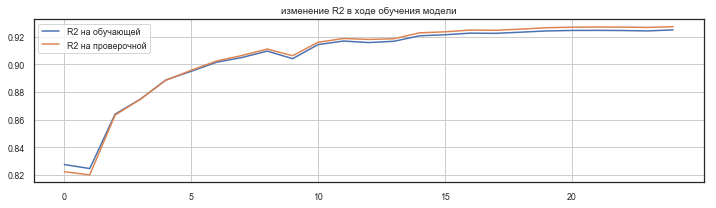

In [77]:
plt.figure(figsize=(12, 3))
ax = plt.subplot()
plt.plot( np.arange(current_epoch - len(R2_OnTrain), current_epoch, step=1) , R2_OnTrain ,  label= u"R2 на обучающей")
plt.plot( np.arange(current_epoch - len(R2_OnTest),  current_epoch, step=1) , R2_OnTest  ,  label= u"R2 на проверочной")
plt.title(u"изменение R2 в ходе обучения модели")
plt.legend()

major_ticks = np.arange(current_epoch - len(R2_OnTrain), current_epoch, 5)

ax.set_xticks(major_ticks)
plt.grid(True)

In [79]:
# Описание структуры модели

for mod in net.modules:
    print("Module:", mod.name)
    if mod.paramdim > 0:
        print("--parameters:", mod.params)
    for conn in net.connections[mod]:
        print("-connection to", conn.outmod.name)
        if conn.paramdim > 0:
             print("- parameters", conn.params)
    if hasattr(net, "recurrentConns"):
        print("Recurrent connections")
        for conn in net.recurrentConns:
            print("-", conn.inmod.name, " to", conn.outmod.name)
            if conn.paramdim > 0:
                print("- parameters", conn.params)

('Module:', 'out')
('Module:', 'hidden1')
('-connection to', 'out')
('- parameters', array([-0.73869743, -0.05175546,  1.50636176,  0.24972433, -0.13336546,
        1.0066444 ]))
('Module:', 'in')
('-connection to', 'hidden0')
('- parameters', array([-0.33961278,  0.13882943,  0.36392889,  0.09816159, -0.78475221,
        0.7659796 ,  1.3261379 ,  0.3414794 , -0.28501523,  0.27599832,
       -1.33547184, -0.41961848,  0.93952518,  0.76109638, -0.30091922,
       -0.5059387 , -0.81294464, -0.77436611]))
('Module:', 'hidden0')
('-connection to', 'hidden1')
('- parameters', array([-1.0180033 ,  1.54461206, -0.43410072,  1.67823875,  0.66746201,
       -0.70782724,  2.39947855, -1.01272507, -0.49075549,  0.5220014 ,
       -0.61628766,  1.59273356,  2.11323572, -1.17668091,  0.37055312,
        0.78376267, -1.94507751, -0.76091406, -0.0246517 , -1.12849764,
       -0.44126988, -0.9665328 , -0.23309263,  3.01331228, -1.14177874,
        1.20078431, -1.06896439, -1.60913537,  0.60265555, -1.

Проверка. Обучающая выборка

In [81]:
y_pred_OnTrain = list()
for inp, tar in ds:
     y_pred_OnTrain.append( [net.activate(inp)[0]])

In [83]:
y_pred_OnTrain[:5]

[[0.34245846592685325],
 [0.7061502908330067],
 [0.46748915191236873],
 [0.8106501974619527],
 [0.40590475150304683]]

In [84]:
print "Нейронная сеть"
r2_net_OnTrain  = metrics.r2_score                   (y_train, y_pred_OnTrain)
mae_net         = metrics.mean_absolute_error        (y_train, y_pred_OnTrain)
mse_net         = metrics.mean_squared_error         (y_train, y_pred_OnTrain) 
rmse_net        = np.sqrt( mse_LinRegr )

print "MAE  {:>10,.6f} - средняя абсолютная ошибка.".format( mae_net)
print "MSE  {:>10,.6f} - средреквадратичная ошибка.".format( mse_net )
print "RMSE {:>10,.6f} - кв. корень из средреквадратичной ошибки.".format( rmse_net )
print "R2   {:>10,.6f} - коэфф. детерминации.".format( r2_net_OnTrain )

Нейронная сеть
MAE    0.048858 - средняя абсолютная ошибка.
MSE    0.003832 - средреквадратичная ошибка.
RMSE   0.120973 - кв. корень из средреквадратичной ошибки.
R2     0.925045 - коэфф. детерминации.


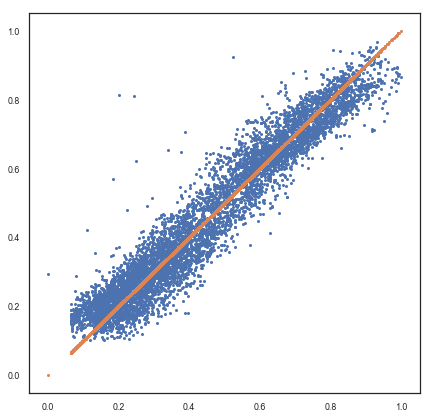

In [86]:
plt.figure(figsize=(7,7))
plt.scatter(y_train, y_pred_OnTrain, s=4)
plt.scatter(y_train, y_train,        s=4)

Проверка. Отложенная выборка

In [88]:
y_pred_OnTest = list()
for inp in x_test.values:
    #print inp, net.activate(inp)
    y_pred_OnTest.append( [net.activate(inp)[0] ] )

In [89]:
print len(y_pred_OnTest), len(x_test), len(y_pred_OnTest) == len(x_test) 
y_pred_OnTest[:5]

2871 2871 True


[[0.6737470308501625],
 [0.25347583272604723],
 [0.5763591700356362],
 [0.2701270953057435],
 [0.34586402277268735]]

In [91]:
print "Нейронная сеть"
r2_net_OnTest  = metrics.r2_score            (y_test, y_pred_OnTest)
mae_net         = metrics.mean_absolute_error (y_test, y_pred_OnTest)
mse_net         = metrics.mean_squared_error  (y_test, y_pred_OnTest) 
rmse_net        = np.sqrt( mse_LinRegr )

dictModel_neuroNet2["name"]      = u"Нейросеть 2вх, 1 вых. 75 итераций"
dictModel_neuroNet2["typeML"]      = u"Нейронная сеть"
dictModel_neuroNet2["r2"]        = r2_net_OnTest
dictModel_neuroNet2["mae"]       = mae_net
dictModel_neuroNet2["mse"]       = mse_net
dictModel_neuroNet2["features"]  = features
dictModel_neuroNet2["target"]    = target
dictModel_neuroNet2["dataNormalised"]    = True

print "MAE  {:>10,.6f} - средняя абсолютная ошибка.".format( mae_net)
print "MSE  {:>10,.6f} - средреквадратичная ошибка.".format( mse_net )
print "RMSE {:>10,.6f} - кв. корень из средреквадратичной ошибки.".format( rmse_net )
print "R2   {:>10,.6f} - коэфф. детерминации.".format( r2_net_OnTest )

Нейронная сеть
MAE    0.047741 - средняя абсолютная ошибка.
MSE    0.003702 - средреквадратичная ошибка.
RMSE   0.120973 - кв. корень из средреквадратичной ошибки.
R2     0.927413 - коэфф. детерминации.


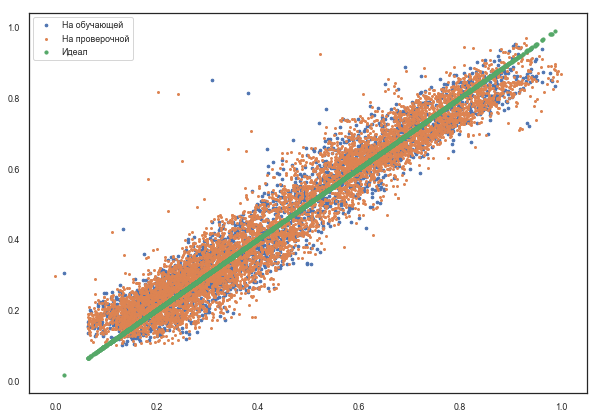

In [93]:
fig=plt.figure(figsize=(10,7))
ax = fig.subplots()

ax.scatter(y_test,  y_pred_OnTest  , s=7, label=u'На обучающей'  )
ax.scatter(y_train, y_pred_OnTrain,  s=4, label=u'На проверочной'  )
ax.scatter(y_test,  y_test,          s=10, label=u'Идеал' )
ax.legend(loc="best")

Сохранение обученной модели в файл

In [95]:
#сохраним модель нейнронной сети
import pickle
# имя файла
fileName_net = "model_Net_3to1.data_pickle"

# операция записи в файл
with open(fileName_net, 'wb') as f:
    pickle.dump(net, f)

## 2.2. Перебор комбинаций структуры сети

In [98]:
# границы диапазона кол-ва узлов для каждого скрытого слоя. Для процедуры поиска лучшей модели 
inLayer=2
outLayer=1

hidLayer0_min = 0
hidLayer0_max = 18
hidLayer0_step = 3

hidLayer1_min = 0
hidLayer1_max = 15
hidLayer1_step = 3

hidLayer2_min = 0
hidLayer2_max = 9
hidLayer2_step = 3

In [100]:
# подготовить объект хранилище данных для 
# Создать объект для хнаранения 2 входных и 1 выходного значения
ds88 = SupervisedDataSet(2, 1)

In [102]:
ds88.clear()
ds88.setField('input',  x_train[features])
ds88.setField('target', y_train[target])

In [104]:
if ( (len(x_train) == ds88.getLength()) ):
    print "Добавление данных прошло успешно."
else:
    print "Не совпадает кол-во элементов. При добавлении данных возникли проблемы."

Добавление данных прошло успешно.


In [106]:
# combinatonSet множество комбинаций кол-ва узлов в скрытых слоях нейронной сети
combinatonSet = set()

epoch_count = 4 # ко-во итераций обучения для каждого варианта

result_R2_MAE = dict()

# перебор возможных комбинаций с 
# обучение модели, получение метрики R2
for zero in range(hidLayer0_min, hidLayer0_max, hidLayer0_step):
    for first in range(hidLayer1_min, hidLayer1_max, hidLayer1_step):
        for second in range(hidLayer2_min, hidLayer2_max, hidLayer2_step):
            net88 = None
            netCode_truple = None

            if   ( zero>0 and first>0 and second>0 
                          and not (inLayer, zero,  first,  second, outLayer) in combinatonSet):
                netCode_truple  = (inLayer, zero,  first,  second, outLayer)
                print "in:{}, z:{}, f:{}, s:{}, out:{}".format(inLayer, zero,  first,  second, outLayer)
                combinatonSet.add(  (inLayer, zero,  first,  second, outLayer) )
                net88 = buildNetwork(inLayer, zero,  first,  second, outLayer)
                
            elif ( zero>0 and first>0
                          and not (inLayer, zero, first, outLayer) in combinatonSet):
                netCode_truple  = (inLayer, zero, first, outLayer)
                print "in:{}, z:{}, f:{}, out:{}".format(inLayer, zero,  first, outLayer)
                combinatonSet.add(  (inLayer, zero,  first, outLayer) )
                net88 = buildNetwork(inLayer, zero,  first, outLayer)
                
            elif ( zero>0 and not (inLayer, zero, outLayer) in combinatonSet):
                netCode_truple  = (inLayer, zero, outLayer)
                print "in:{}, z:{}, out:{}".format(inLayer, zero, outLayer)
                combinatonSet.add(  (inLayer, zero, outLayer) )
                net88 = buildNetwork(inLayer, zero, outLayer)
                
            else:
                pass
                #print "all Zerooo"
                
            if (net88 is not None):
                # обучить
                trainerSellHouse88 = BackpropTrainer(net88, ds88)
                ###### print "Квадратична ошибка:  {:>10,.6f}".format(
                trainerSellHouse88.trainEpochs(epochs=7) 
                
                # Вычислить ответ сети на проверочной части
                y_pred_OnTest88 = list()
                for inp in x_test.values:
                    y_pred_OnTest88.append( [net88.activate(inp)[0] ] )
                
                # расчитать метрики точности
                r2_net88   = metrics.r2_score            (y_test, y_pred_OnTest88)
                mae_net88  = metrics.mean_absolute_error (y_test, y_pred_OnTest88)
                mse_net88  = metrics.mean_squared_error  (y_test, y_pred_OnTest88) 
                rmse_net88 = np.sqrt( mse_net88 )
                
                result_R2_MAE[netCode_truple] = (r2_net88,  mae_net88, mse_net88, rmse_net88 )

                print "MAE  {:>10,.6f} - средняя абсолютная ошибка.".format( mae_net88)
                print "MSE  {:>10,.6f} - средреквадратичная ошибка.".format( mse_net88 )
                print "RMSE {:>10,.6f} - кв. корень из средреквадратичной ошибки.".format( rmse_net88 )
                print "R2 Пров.  {:>10,.6f} - коэфф. детерминации.".format( r2_net88 )
                print ""
                
            pass

in:2, z:3, out:1
MAE    0.059162 - средняя абсолютная ошибка.
MSE    0.005478 - средреквадратичная ошибка.
RMSE   0.074013 - кв. корень из средреквадратичной ошибки.
R2 Пров.    0.892581 - коэфф. детерминации.

in:2, z:3, f:3, out:1
MAE    0.047986 - средняя абсолютная ошибка.
MSE    0.003736 - средреквадратичная ошибка.
RMSE   0.061121 - кв. корень из средреквадратичной ошибки.
R2 Пров.    0.926743 - коэфф. детерминации.

in:2, z:3, f:3, s:3, out:1
MAE    0.050646 - средняя абсолютная ошибка.
MSE    0.004073 - средреквадратичная ошибка.
RMSE   0.063818 - кв. корень из средреквадратичной ошибки.
R2 Пров.    0.920134 - коэфф. детерминации.

in:2, z:3, f:3, s:6, out:1
MAE    0.199483 - средняя абсолютная ошибка.
MSE    0.052013 - средреквадратичная ошибка.
RMSE   0.228064 - кв. корень из средреквадратичной ошибки.
R2 Пров.   -0.019957 - коэфф. детерминации.

in:2, z:3, f:6, out:1
MAE    0.060756 - средняя абсолютная ошибка.
MSE    0.005686 - средреквадратичная ошибка.
RMSE   0.075402 - к

MAE    0.051147 - средняя абсолютная ошибка.
MSE    0.004171 - средреквадратичная ошибка.
RMSE   0.064581 - кв. корень из средреквадратичной ошибки.
R2 Пров.    0.918213 - коэфф. детерминации.

in:2, z:12, out:1
MAE    0.051374 - средняя абсолютная ошибка.
MSE    0.004299 - средреквадратичная ошибка.
RMSE   0.065565 - кв. корень из средреквадратичной ошибки.
R2 Пров.    0.915703 - коэфф. детерминации.

in:2, z:12, f:3, out:1
MAE    0.049304 - средняя абсолютная ошибка.
MSE    0.003989 - средреквадратичная ошибка.
RMSE   0.063156 - кв. корень из средреквадратичной ошибки.
R2 Пров.    0.921783 - коэфф. детерминации.

in:2, z:12, f:3, s:3, out:1
MAE    0.056578 - средняя абсолютная ошибка.
MSE    0.005013 - средреквадратичная ошибка.
RMSE   0.070800 - кв. корень из средреквадратичной ошибки.
R2 Пров.    0.901703 - коэфф. детерминации.

in:2, z:12, f:3, s:6, out:1
MAE    0.047569 - средняя абсолютная ошибка.
MSE    0.003734 - средреквадратичная ошибка.
RMSE   0.061110 - кв. корень из средр

In [108]:
print "Матрицы для хранения значений метрик. Размерность :",
heatR2  = np.zeros( (hidLayer0_max, hidLayer1_max) )
heatMAE = np.zeros( (hidLayer0_max, hidLayer1_max) )
heatMSE = np.zeros( (hidLayer0_max, hidLayer1_max) )
print heatMAE.shape

Матрицы для хранения значений метрик. Размерность : (18L, 15L)


Кол-во узлов в Скрытом Слое №2 == 0

In [110]:
# из словаря с результатами выбрать значения метрик и перенести в промежуточные списки
for key in result_R2_MAE:
    nz = key[1]
    nf = key[2] if (len(key) >= 4) else 0
    ns = key[3] if (len(key) >= 5) else 0
    
    print len(key), key, nz, nf, ns
 
    # выбрать значения метрик для комбинаций: Кол-во узлов в СкрытомСлое№2 == 0 
    if(ns == 0):
        heatR2  [nz-1][nf-1] = result_R2_MAE[key][0]
        heatMAE [nz-1][nf-1] = result_R2_MAE[key][1]
        heatMSE [nz-1][nf-1] = result_R2_MAE[key][2]

4 (2, 15, 6, 1) 15 6 0
5 (2, 15, 6, 6, 1) 15 6 6
5 (2, 12, 12, 6, 1) 12 12 6
5 (2, 12, 3, 6, 1) 12 3 6
5 (2, 3, 6, 6, 1) 3 6 6
5 (2, 15, 9, 3, 1) 15 9 3
4 (2, 3, 3, 1) 3 3 0
4 (2, 6, 3, 1) 6 3 0
5 (2, 9, 6, 6, 1) 9 6 6
5 (2, 6, 3, 6, 1) 6 3 6
5 (2, 12, 9, 3, 1) 12 9 3
5 (2, 6, 6, 6, 1) 6 6 6
5 (2, 6, 3, 3, 1) 6 3 3
4 (2, 12, 6, 1) 12 6 0
4 (2, 3, 12, 1) 3 12 0
5 (2, 9, 12, 3, 1) 9 12 3
5 (2, 15, 12, 6, 1) 15 12 6
5 (2, 3, 9, 3, 1) 3 9 3
5 (2, 6, 9, 6, 1) 6 9 6
5 (2, 9, 9, 3, 1) 9 9 3
5 (2, 3, 9, 6, 1) 3 9 6
4 (2, 6, 6, 1) 6 6 0
4 (2, 9, 12, 1) 9 12 0
3 (2, 3, 1) 3 0 0
5 (2, 9, 9, 6, 1) 9 9 6
5 (2, 3, 6, 3, 1) 3 6 3
3 (2, 15, 1) 15 0 0
3 (2, 9, 1) 9 0 0
5 (2, 12, 3, 3, 1) 12 3 3
5 (2, 15, 9, 6, 1) 15 9 6
5 (2, 12, 9, 6, 1) 12 9 6
5 (2, 6, 9, 3, 1) 6 9 3
5 (2, 12, 6, 6, 1) 12 6 6
4 (2, 3, 9, 1) 3 9 0
4 (2, 6, 9, 1) 6 9 0
5 (2, 3, 3, 3, 1) 3 3 3
5 (2, 15, 12, 3, 1) 15 12 3
5 (2, 3, 3, 6, 1) 3 3 6
4 (2, 9, 9, 1) 9 9 0
5 (2, 12, 12, 3, 1) 12 12 3
3 (2, 6, 1) 6 0 0
5 (2, 9, 6, 3, 1) 9 6 3
4 

Темнее - лучше


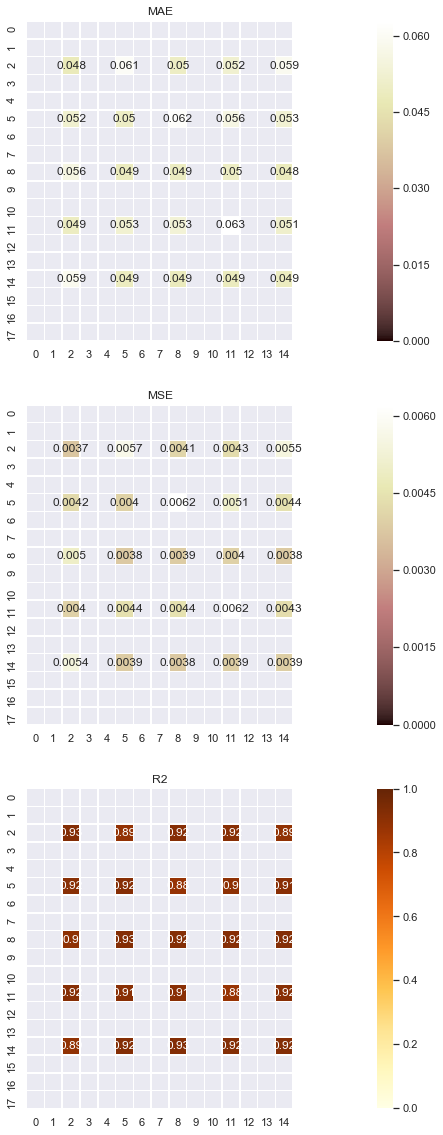

In [113]:
# Построить тепловую катру значений метрик для нейронных сетей. Кол-во узлов в СкрытомСлое№2 == 0 
%config InlineBackend.figure_format = 'png' 
sns.set(font_scale=1) # размер шрифта

plt.figure(figsize=(30,20))


pdMAE = pd.DataFrame(heatMAE)
pdMSE = pd.DataFrame(heatMSE)
pdR2 = pd.DataFrame(heatR2)

ax1 = plt.subplot(3,1,1)
sns.heatmap(  
    data= pdMAE[pdMAE!= 0],
    cmap="pink",
    annot=True, # вывод значений
    square=True,
    linewidths=0.5,
    vmin=0,  vmax=heatMAE.max(), # граничные значения для цветовой карты 
)
plt.title("MAE")

ax2 = plt.subplot(3,1,2)
sns.heatmap(  
    data= pdMSE[pdMSE!= 0],
    cmap="pink",
    annot=True, # вывод значений
    square=True,
    linewidths=0.5,
    vmin=0, vmax=heatMSE.max(), # граничные значения для цветовой карты 
)
plt.title("MSE")

ax3 = plt.subplot(3,1,3)
sns.heatmap(  
    data=  pdR2[pdR2!= 0],
    cmap="YlOrBr",
    annot=True, # вывод значений
    square=True,
    linewidths=0.5,
    vmin=0, vmax=1, # граничные значения для цветовой карты 
)
plt.title("R2")
print "Темнее - лучше"

Кол-во узлов в СкрытомСлое№2 == 3

In [115]:
# из словаря с результатами выбрать значения и перенести в промежуточные списки
for key in result_R2_MAE:
    nz = key[1]
    nf = key[2] if (len(key) >= 4) else 0
    ns = key[3] if (len(key) >= 5) else 0
    
    print len(key), key, nz, nf, ns
 
    # выбрать значения метрик для комбинаций: Кол-во узлов в СкрытомСлое№2 == 0 
    if(ns == 3):
        heatR2  [nz-1][nf-1] = result_R2_MAE[key][0]
        heatMAE [nz-1][nf-1] = result_R2_MAE[key][1]
        heatMSE [nz-1][nf-1] = result_R2_MAE[key][2]

4 (2, 15, 6, 1) 15 6 0
5 (2, 15, 6, 6, 1) 15 6 6
5 (2, 12, 12, 6, 1) 12 12 6
5 (2, 12, 3, 6, 1) 12 3 6
5 (2, 3, 6, 6, 1) 3 6 6
5 (2, 15, 9, 3, 1) 15 9 3
4 (2, 3, 3, 1) 3 3 0
4 (2, 6, 3, 1) 6 3 0
5 (2, 9, 6, 6, 1) 9 6 6
5 (2, 6, 3, 6, 1) 6 3 6
5 (2, 12, 9, 3, 1) 12 9 3
5 (2, 6, 6, 6, 1) 6 6 6
5 (2, 6, 3, 3, 1) 6 3 3
4 (2, 12, 6, 1) 12 6 0
4 (2, 3, 12, 1) 3 12 0
5 (2, 9, 12, 3, 1) 9 12 3
5 (2, 15, 12, 6, 1) 15 12 6
5 (2, 3, 9, 3, 1) 3 9 3
5 (2, 6, 9, 6, 1) 6 9 6
5 (2, 9, 9, 3, 1) 9 9 3
5 (2, 3, 9, 6, 1) 3 9 6
4 (2, 6, 6, 1) 6 6 0
4 (2, 9, 12, 1) 9 12 0
3 (2, 3, 1) 3 0 0
5 (2, 9, 9, 6, 1) 9 9 6
5 (2, 3, 6, 3, 1) 3 6 3
3 (2, 15, 1) 15 0 0
3 (2, 9, 1) 9 0 0
5 (2, 12, 3, 3, 1) 12 3 3
5 (2, 15, 9, 6, 1) 15 9 6
5 (2, 12, 9, 6, 1) 12 9 6
5 (2, 6, 9, 3, 1) 6 9 3
5 (2, 12, 6, 6, 1) 12 6 6
4 (2, 3, 9, 1) 3 9 0
4 (2, 6, 9, 1) 6 9 0
5 (2, 3, 3, 3, 1) 3 3 3
5 (2, 15, 12, 3, 1) 15 12 3
5 (2, 3, 3, 6, 1) 3 3 6
4 (2, 9, 9, 1) 9 9 0
5 (2, 12, 12, 3, 1) 12 12 3
3 (2, 6, 1) 6 0 0
5 (2, 9, 6, 3, 1) 9 6 3
4 

Темнее - лучше


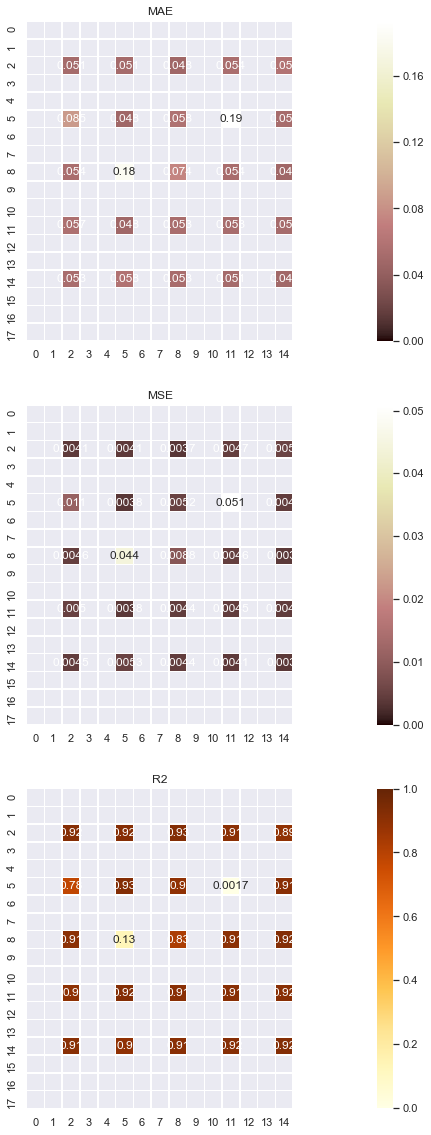

In [116]:
# Построить тепловую катру значений метрик для нейронных сетей. Кол-во узлов в СкрытомСлое№2 == 3 
%config InlineBackend.figure_format = 'png' 
sns.set(font_scale=1) # размер шрифта

plt.figure(figsize=(30,20))


pdMAE = pd.DataFrame(heatMAE)
pdMSE = pd.DataFrame(heatMSE)
pdR2 = pd.DataFrame(heatR2)

ax1 = plt.subplot(3,1,1)
sns.heatmap(  
    data= pdMAE[pdMAE!= 0],
    cmap="pink",
    annot=True, # вывод значений
    square=True,
    linewidths=0.5,
    vmin=0,  vmax=heatMAE.max(), # граничные значения для цветовой карты 
)
plt.title("MAE")

ax2 = plt.subplot(3,1,2)
sns.heatmap(  
    data= pdMSE[pdMSE!= 0],
    cmap="pink",
    annot=True, # вывод значений
    square=True,
    linewidths=0.5,
    vmin=0, vmax=heatMSE.max(), # граничные значения для цветовой карты 
)
plt.title("MSE")

ax3 = plt.subplot(3,1,3)
sns.heatmap(  
    data=  pdR2[pdR2!= 0],
    cmap="YlOrBr",
    annot=True, # вывод значений
    square=True,
    linewidths=0.5,
    vmin=0, vmax=1, # граничные значения для цветовой карты 
)
plt.title("R2")
print "Темнее - лучше"

Отдельно R2

0
3
6


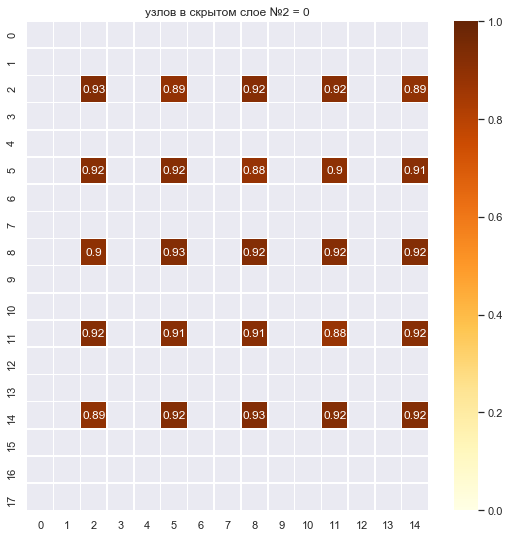

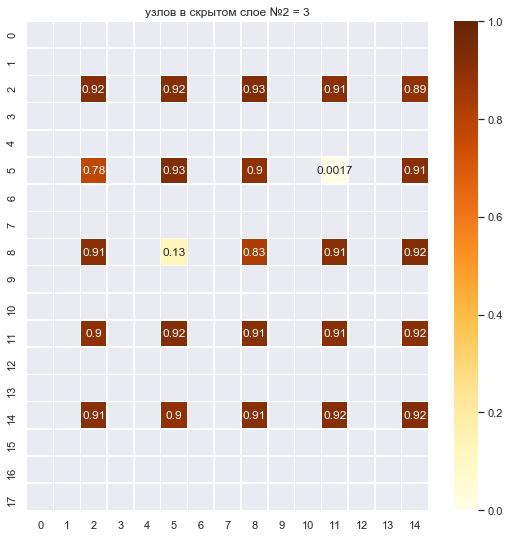

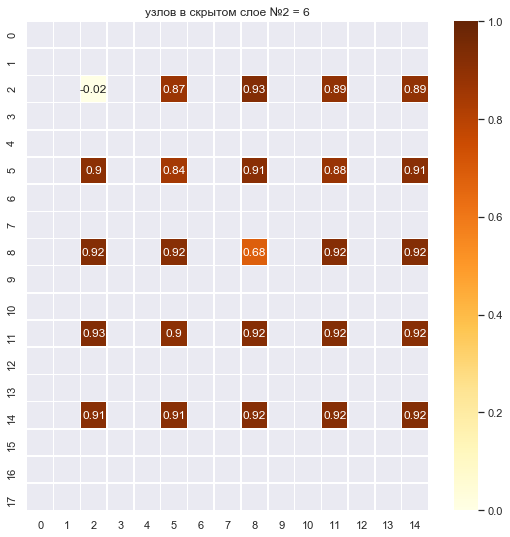

In [117]:
for secondCOunt in range(0, hidLayer2_max, hidLayer2_step):
    print secondCOunt
    
    # из словаря с результатами выбрать значения и перенести в промежуточные списки
    for key in result_R2_MAE:
        nz = key[1]
        nf = key[2] if (len(key) >= 4) else 0
        ns = key[3] if (len(key) >= 5) else 0

        # выбрать значения метрик для комбинаций: Кол-во узлов в СкрытомСлое№2 == 0 
        if(ns == secondCOunt):
            # print len(key), key, nz, nf, ns
            heatR2  [nz-1][nf-1] = result_R2_MAE[key][0]
            heatMAE [nz-1][nf-1] = result_R2_MAE[key][1]
            heatMSE [nz-1][nf-1] = result_R2_MAE[key][2]
            
    plt.figure(figsize=(9,9))
    pdR2 = pd.DataFrame(heatR2)
    sns.heatmap(  
        data=  pdR2[pdR2 != 0],
        cmap="YlOrBr",
        annot=True, # вывод значений
        #square=True,
        linewidths=0.5,
        vmin=0, vmax=1, # граничные значения для цветовой карты 
    )
    plt.title(u"узлов в скрытом слое №2 = "+ str(secondCOunt))
    pass

## 2.3. Сеть. Все числовые параметры

Формирование тестовой и обучающей выборки. Все чсловые столбцы

In [118]:
valid_size = 0.3 # доля тестовой части в выборке
rand_seed = 8 # начальное состояние генератора случ. чисел

x_trainAll, x_testAll, y_trainAll, y_testAll =  train_test_split(
    dataNumeric.drop(columns=target), dataNumeric[target], # исходные данные
    test_size = valid_size, 
    random_state=rand_seed, 
    shuffle=True # перемешивание
) 
print "Кол-во элементов: \n  x_train: {}, y_train {} \n  x_test:  {}, y_test  {} \n  total x: {}, total y {} ".format  (
    len(x_train), len(y_train),
    len(x_test),  len(x_test), 
    len(x_train)+len(x_test), len(y_train)+len(x_test),
)

Кол-во элементов: 
  x_train: 6697, y_train 6697 
  x_test:  2871, y_test  2871 
  total x: 9568, total y 9568 


In [119]:
netAll = None

firstLayerCount = len(x_trainALLF_Norm.columns)
print "Кол-во входных признаков", len(x_trainALLF_Norm.columns)
print x_trainALLF_Norm.columns

netAll = buildNetwork(firstLayerCount, firstLayerCount*2, 7, 1)

Кол-во входных признаков 4
Index([u'Temperature', u'Vacuum', u'Pressure', u'Humidity'], dtype='object')


In [120]:
print netAll

FeedForwardNetwork-1805
   Modules:
    [<BiasUnit 'bias'>, <LinearLayer 'in'>, <SigmoidLayer 'hidden0'>, <SigmoidLayer 'hidden1'>, <LinearLayer 'out'>]
   Connections:
    [<FullConnection 'FullConnection-1799': 'in' -> 'hidden0'>, <FullConnection 'FullConnection-1800': 'hidden1' -> 'out'>, <FullConnection 'FullConnection-1801': 'hidden0' -> 'hidden1'>, <FullConnection 'FullConnection-1802': 'bias' -> 'out'>, <FullConnection 'FullConnection-1803': 'bias' -> 'hidden0'>, <FullConnection 'FullConnection-1804': 'bias' -> 'hidden1'>]



In [122]:
# Создать объект для хранения 4 входных и 1 выходного значения
dsAll = SupervisedDataSet(firstLayerCount, 1)

In [123]:
len(x_trainALLF_Norm.columns)

4

In [124]:
dsAll.clear()
dsAll.setField('input',  x_trainALLF_Norm)
dsAll.setField('target', y_trainALLF_Norm[target])

In [125]:
if ( (len(x_trainALLF_Norm) == dsAll.getLength()) ):
    print "Добавление данных прошло успешно.", len(x_trainALLF_Norm)
else:
    print "Не совпадает кол-во элементов. При добавлении данных возникли проблемы.", len(x_trainALLF_Norm), dsAll.getLength()

Добавление данных прошло успешно. 6697


Сверим данные тренировочной части в объекте SupervisedDataSet и источнике

In [126]:
print "SupervisedDataSet \n", dsAll.getSample(10)
print "x_train           \n", x_trainALLF_Norm.iloc[10].values, y_trainALLF_Norm[target].iloc[10].values

SupervisedDataSet 
[array([0.64135977, 0.76992883, 0.50705271, 0.2652815 ]), array([0.34529801])]
x_train           
[0.64135977 0.76992883 0.50705271 0.2652815 ] [0.34529801]


In [127]:
print "SupervisedDataSet "
print dsAll['input'][:3]

SupervisedDataSet 
[[0.51529745 0.78505338 0.44939371 0.8036193 ]
 [0.24305949 0.34679715 0.52783964 0.70857909]
 [0.49036827 0.44128114 0.4610245  0.99396783]]


In [128]:
print "x_train           "
print x_trainALLF_Norm[:3]

x_train           
      Temperature  Vacuum  Pressure  Humidity
6630        0.515   0.785     0.449     0.804
7447        0.243   0.347     0.528     0.709
5127        0.490   0.441     0.461     0.994


In [129]:
print "SupervisedDataSet "
print dsAll['target'][:3]

SupervisedDataSet 
[[0.37788079]
 [0.76543046]
 [0.41364238]]


In [130]:
print "y_train           "
print y_trainALLF_Norm[:3]

y_train           
      EnergyOutput
6630         0.378
7447         0.765
5127         0.414


Обучение

In [131]:
trainerSellHouseAll = BackpropTrainer(netAll, dsAll)

In [132]:
print "Обучение ...", 
trainerSellHouseAll.trainEpochs(4)
print " проведено"

Обучение ...  проведено


Проверка. Обучающая выборка

In [133]:
y_pred_OnTrainAll = list()
for inp, tar in dsAll:
     y_pred_OnTrainAll.append( [netAll.activate(inp)[0]])

In [134]:
y_pred_OnTrainAll[:3]

[[0.3147130037425203], [0.68224099872757], [0.4091721004283788]]

In [135]:
print "Нейронная сеть"
r2_net   = metrics.r2_score                   (y_trainALLF_Norm, y_pred_OnTrainAll)
mae_net  = metrics.mean_absolute_error        (y_trainALLF_Norm, y_pred_OnTrainAll)
mse_net  = metrics.mean_squared_error         (y_trainALLF_Norm, y_pred_OnTrainAll) 
rmse_net = np.sqrt( mse_net )


print "MAE  {:>10,.6f} - средняя абсолютная ошибка.".format( mae_net)
print "MSE  {:>10,.6f} - средреквадратичная ошибка.".format( mse_net )
print "RMSE {:>10,.6f} - кв. корень из средреквадратичной ошибки.".format( rmse_net )
print "R2   {:>10,.6f} - коэфф. детерминации.".format( r2_net )

Нейронная сеть
MAE    0.052611 - средняя абсолютная ошибка.
MSE    0.004419 - средреквадратичная ошибка.
RMSE   0.066478 - кв. корень из средреквадратичной ошибки.
R2     0.913566 - коэфф. детерминации.


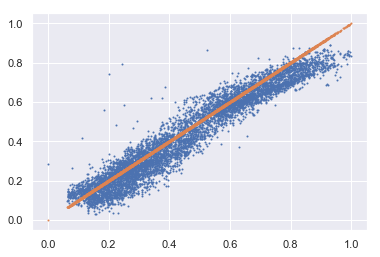

In [136]:
plt.scatter(y_trainALLF_Norm, y_pred_OnTrainAll, s=1)
plt.scatter(y_trainALLF_Norm, y_trainALLF_Norm,        s=1)

In [137]:
y_pred_OnTestAll = list()
for inp in x_testALLF_Norm.values:
    #print inp, net.activate(inp)
    y_pred_OnTestAll.append( [netAll.activate(inp)[0] ] )

In [138]:
print "Нейронная сеть"
r2           = metrics.r2_score                   (y_testALLF_Norm, y_pred_OnTestAll)
mae_tree     = metrics.mean_absolute_error        (y_testALLF_Norm, y_pred_OnTestAll)
mse_LinRegr  = metrics.mean_squared_error         (y_testALLF_Norm, y_pred_OnTestAll) 
rmse_LinRegr = np.sqrt( mse_LinRegr )


print "MAE  {:>10,.6f} - средняя абсолютная ошибка.".format( mae_tree)
print "MSE  {:>10,.6f} - средреквадратичная ошибка.".format( mse_LinRegr )
print "RMSE {:>10,.6f} - кв. корень из средреквадратичной ошибки.".format( rmse_LinRegr )
print "R2   {:>10,.6f} - коэфф. детерминации.".format( r2 )

Нейронная сеть
MAE    0.052316 - средняя абсолютная ошибка.
MSE    0.004336 - средреквадратичная ошибка.
RMSE   0.065848 - кв. корень из средреквадратичной ошибки.
R2     0.914973 - коэфф. детерминации.


In [139]:
dot_size = 1

Text(0,0.5,u'\u041a\u0432\u0430\u0434\u0440\u0430\u0442 \u0437\u043d\u0430\u0447\u0435\u043d\u0438\u044f \u043e\u0448\u0438\u0431\u043a\u0438 \u043c\u043e\u0434\u0435\u043b\u0438 Y')

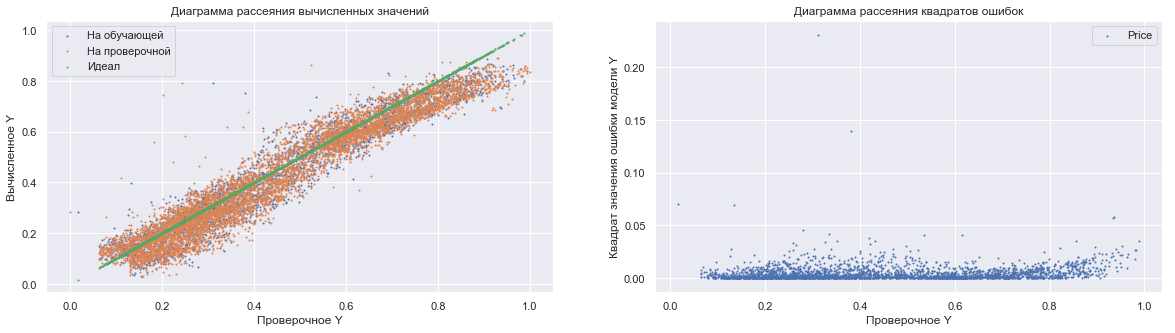

In [140]:
# Графики на одном полотне
plt.figure(figsize=(20,5))

# создать первое полотно 121: 1-строк, 2-столбцов, 1-индекс в сетке
plt.subplot(121)
plt.scatter(y_testALLF_Norm,  y_pred_OnTestAll  , s=dot_size, label=u'На обучающей'  )
plt.scatter(y_trainALLF_Norm, y_pred_OnTrainAll,  s=dot_size, label=u'На проверочной'  )
plt.scatter(y_testALLF_Norm,  y_testALLF_Norm,          s=1, label=u'Идеал' )
plt.legend(loc="best")

plt.title(u'Диаграмма рассеяния вычисленных значений');
plt.xlabel(u'Проверочное Y')
plt.ylabel(u'Вычисленное Y')

# создать второе полотно 122: 1-строк, 2-столбцов, 2-индекс в сетке
plt.subplot(122)
plt.scatter(y_testALLF_Norm.values,  pow(abs(y_testALLF_Norm.values - y_pred_OnTestAll),2) , label="Price" , s=dot_size,)
plt.legend(loc="best")
plt.title(u'Диаграмма рассеяния квадратов ошибок');
plt.xlabel(u'Проверочное Y')
plt.ylabel(u'Квадрат значения ошибки модели Y')

In [141]:
# сохраним модель нейнронной сети
import pickle
# имя файла
fileName_net28 = "model_Net_WV.data_pickle"

# операция записи в файл
with open(fileName_net28, 'wb') as f:
    pickle.dump(netAll, f)
print "Модель {} сохнанена в файл \"{}\"".format(netAll.__class__, fileName_net28)

Модель <class 'pybrain.structure.networks.feedforward.FeedForwardNetwork'> сохнанена в файл "model_Net_WV.data_pickle"


# 3. Линейная множественная регрессия

In [142]:
# создать модель
model_LinRegrMult = linear_model.LinearRegression()

# обучить модель на тренировочной части выборки
model_LinRegrMult.fit(x_train, y_train)

# получить вычисленное значения на проверочной части выборки
y_pred_LinRegrMult = model_LinRegrMult.predict(x_test)

In [143]:
print "Множественная линейная регрессия. Полный диапазон."
print "y_pred_lin_reg_mult (x1, x2) =\n   {:,.3f}*{:} + {:,.3f}*{:} + {:,.3f}\n".format(
    model_LinRegrMult.coef_[0][0], features[0],
    model_LinRegrMult.coef_[0][1], features[1],
    model_LinRegrMult.intercept_[0])

mae_LinRegrMult = metrics.mean_absolute_error(y_test, y_pred_LinRegrMult)
r2_LinRegrMult  = metrics.r2_score           (y_test, y_pred_LinRegrMult)
mse_LinRegrMult = metrics.mean_squared_error     (y_test, y_pred_LinRegrMult)

dictModel_linear["name"]      = u"Множественная"
dictModel_linear["typeML"]      = u"Линейная регрессия"
dictModel_linear["r2"]        = r2_LinRegrMult
dictModel_linear["mae"]       = mae_LinRegrMult
dictModel_linear["mse"]       = mse_LinRegrMult
dictModel_linear["features"]  = ["RH","ISI"]
dictModel_linear["target"]    = ["temp"]
dictModel_linear["dataNormalised"]    = True

print "MAE - Cредняя абсолютная ошибка: {:>7,.2f}".format( mae_LinRegrMult )
print "R2 - коэфф. детерминации:        {:>7,.3f}".format( r2_LinRegrMult )

Множественная линейная регрессия. Полный диапазон.
y_pred_lin_reg_mult (x1, x2) =
   -0.793*Temperature + -0.244*Vacuum + 0.978

MAE - Cредняя абсолютная ошибка:    0.05
R2 - коэфф. детерминации:          0.918


Text(0.5,0,u'\u0417\u043d\u0430\u0447\u0435\u043d\u0438\u0435')

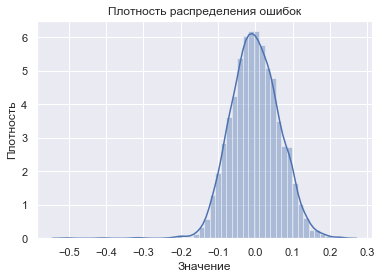

In [144]:
plt.figure(figsize=(6,4))
sns.distplot((y_test - y_pred_LinRegrMult))
plt.title(u'Плотность распределения ошибок');
plt.ylabel(u'Плотность')
plt.xlabel(u'Значение')

Text(0,0.5,u'\u041a\u0432\u0430\u0434\u0440\u0430\u0442 \u0437\u043d\u0430\u0447\u0435\u043d\u0438\u044f \u043e\u0448\u0438\u0431\u043a\u0438 \u043c\u043e\u0434\u0435\u043b\u0438 Y')

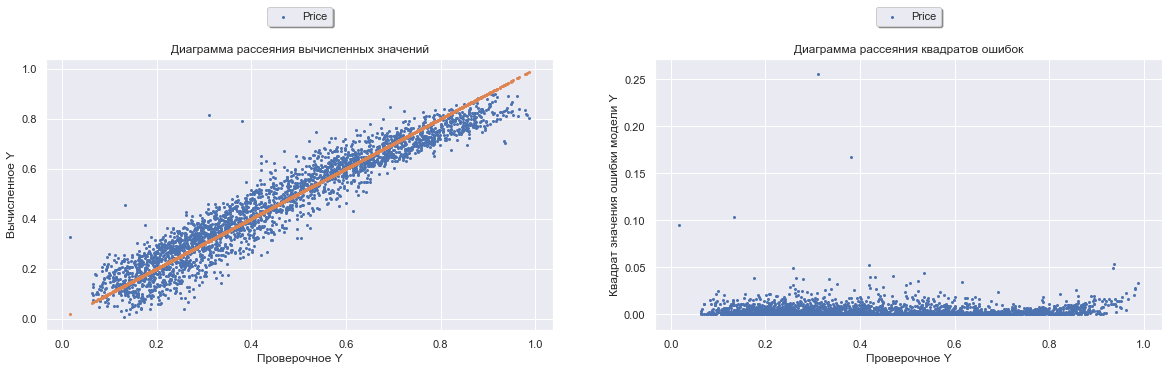

In [145]:
# Графики на одном полотне
plt.figure(figsize=(20,5))
dot_size=4

# создать первое полотно 121: 1-строк, 2-столбцов, 1-индекс в сетке
plt.subplot(121)
plt.scatter(y_test, y_pred_LinRegrMult, label="Price", s=dot_size)
plt.scatter(y_test, y_test, s=dot_size)

plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.1),  ncol=1, fancybox=True, shadow=True)
plt.title(u'Диаграмма рассеяния вычисленных значений');
plt.xlabel(u'Проверочное Y')
plt.ylabel(u'Вычисленное Y')

# создать второе полотно 122: 1-строк, 2-столбцов, 2-индекс в сетке
plt.subplot(122)
plt.scatter(y_test,  pow(abs(y_test - y_pred_LinRegrMult),2) , label="Price" , s=dot_size)

plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.1),  ncol=1, fancybox=True, shadow=True)
plt.title(u'Диаграмма рассеяния квадратов ошибок');
plt.xlabel(u'Проверочное Y')
plt.ylabel(u'Квадрат значения ошибки модели Y')

Получение значения коэфф.

In [146]:
print "# Просмотр коэфф. обученной модели"
print model_LinRegrMult.coef_
print model_LinRegrMult.intercept_
print model_LinRegrMult.get_params()

# Просмотр коэфф. обученной модели
[[-0.79279787 -0.2443391 ]]
[0.97837644]
{'copy_X': True, 'normalize': False, 'n_jobs': None, 'fit_intercept': True}


Сохранение модели (Pickle)

In [147]:
import pickle
fileName_LinRegrMult = "model_LinRegrMult.data_pickle"

with open(fileName_LinRegrMult, 'wb') as f:
    pickle.dump(model_LinRegrMult, f)
print "Модель {} сохнанена в файл \"{}\"".format(model_LinRegrMult.__class__, fileName_LinRegrMult)

Модель <class 'sklearn.linear_model.base.LinearRegression'> сохнанена в файл "model_LinRegrMult.data_pickle"


# 4. Дерево регрессии

Глубина дерева=1, R2_кросс.вал. 0.721, R2 на проверочной части = 0.712
Глубина дерева=2, R2_кросс.вал. 0.86, R2 на проверочной части = 0.856
Глубина дерева=3, R2_кросс.вал. 0.907, R2 на проверочной части = 0.906
Глубина дерева=4, R2_кросс.вал. 0.924, R2 на проверочной части = 0.924
Глубина дерева=5, R2_кросс.вал. 0.93, R2 на проверочной части = 0.930
Глубина дерева=6, R2_кросс.вал. 0.932, R2 на проверочной части = 0.933
Глубина дерева=7, R2_кросс.вал. 0.932, R2 на проверочной части = 0.935
Глубина дерева=8, R2_кросс.вал. 0.931, R2 на проверочной части = 0.933
Глубина дерева=9, R2_кросс.вал. 0.93, R2 на проверочной части = 0.931
Глубина дерева=10, R2_кросс.вал. 0.928, R2 на проверочной части = 0.930
Глубина дерева=11, R2_кросс.вал. 0.927, R2 на проверочной части = 0.931
Глубина дерева=12, R2_кросс.вал. 0.925, R2 на проверочной части = 0.930
Глубина дерева=13, R2_кросс.вал. 0.921, R2 на проверочной части = 0.930
Глубина дерева=14, R2_кросс.вал. 0.919, R2 на проверочной части = 0.925

Мак

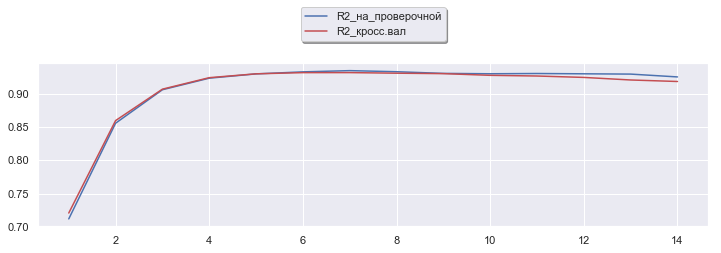

In [148]:
max_depth = 15
tree_seed=1
listR2_Cross = []
listR2_Test = []

for i in range (1,max_depth):
    # создать модель дерева регрессии с очередным значением глубины
    dtRegr = tree.DecisionTreeRegressor(max_depth=i, random_state=tree_seed )
    
    # обучить модель дерева регрессии на тренировочной части выборки
    dtRegr.fit(x_train, y_train)
    
    # получить вычисленние модели на проверочной части выборки
    y_dtRegr = dtRegr.predict(x_test)
    
    # получить оценку R2 на тренировочной подвыборке, разделенной на cv= 5 частей
    scores_cross = cross_val_score(dtRegr, x_train, y_train, cv=5, scoring='r2')
    
    # получить оценку R2 на проверочной подвыборке
    scores_test =  metrics.r2_score(y_test, y_dtRegr)
    
    # сохранение результата
    listR2_Cross.append( scores_cross.mean() )
    listR2_Test.append( scores_test.mean() )
    
   
    ## print ""
    print "Глубина дерева={}, R2_кросс.вал. {:.3}, R2 на проверочной части = {:.3f}".format(
        dtRegr.max_depth, 
        listR2_Cross[i-1],
        listR2_Test[i-1]
    )
    ### print scores_cross
print ""   
print "Максимальный R2= R2_кросс.вал. {:.3}, R2 на проверочной части = {:.3f}".format(
        max(listR2_Cross),
        max(listR2_Test)
    )

plt.figure(figsize=(12, 3))
plt.plot( np.arange(1, max_depth, step=1) , listR2_Test ,  label= u"R2_на_проверочной", c="b")
plt.plot( np.arange(1, max_depth, step=1) , listR2_Cross,  label= u"R2_кросс.вал", c="r")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.1),  ncol=1, fancybox=True, shadow=True)

Значение оптимальной глубины дерева регрессии принимаем равной 6. Приступим к оценке полученной модели.

In [152]:
opt_depth= 6
treeRegr_d6 = tree.DecisionTreeRegressor(max_depth=opt_depth)
treeRegr_d6.fit(x_train, y_train)

# Получить вычислнные значения на проверочном наборе
y_treeRegr_d6 = treeRegr_d6.predict(x_test)

In [155]:
print "Дерево решений. Регрессия. Усеченный диапазон."
mae_tree = metrics.mean_absolute_error(y_test, y_treeRegr_d6)
r2_tree  = metrics.r2_score           (y_test, y_treeRegr_d6)
mse_tree = metrics.mean_squared_error (y_test, y_treeRegr_d6)

dictModel_tree["name"]      = u"Дерево регрессии"
dictModel_tree["typeML"]      = u"Дерево регрессии"
dictModel_tree["r2"]        = r2_tree
dictModel_tree["mae"]       = mae_tree
dictModel_tree["mse"]       = mse_tree
dictModel_tree["features"]  = ["RH","ISI"]
dictModel_tree["target"]    = ["temp"]
dictModel_tree["dataNormalised"]    = True

print "MAE - средняя абсолютная ошибка: {:>7,.3f} дерево регр. ".format( mae_tree)
print "R2  - коэфф. детерминации:       {:>7,.3f} дерево регр. ".format( r2_tree )

Дерево решений. Регрессия. Усеченный диапазон.
MAE - средняя абсолютная ошибка:   0.044 дерево регр. 
R2  - коэфф. детерминации:         0.933 дерево регр. 


Text(0.5,0,u'\u0417\u043d\u0430\u0447\u0435\u043d\u0438\u0435')

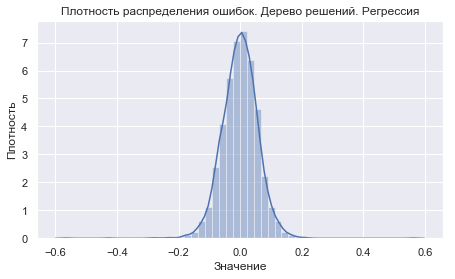

In [158]:
plt.figure(figsize=(16,4))

plt.subplot(121)
sns.distplot((y_test - y_treeRegr_d6.reshape(-1,1)))

plt.title(u'Плотность распределения ошибок. Дерево решений. Регрессия');
plt.ylabel(u'Плотность')
plt.xlabel(u'Значение')

Text(0,0.5,u'\u043a\u0432\u0430\u0434\u0440\u0430\u0442 \u0437\u043d\u0430\u0447\u0435\u043d\u0438\u044f \u043e\u0448\u0438\u0431\u043a\u0438 \u043c\u043e\u0434\u0435\u043b\u0438 Y')

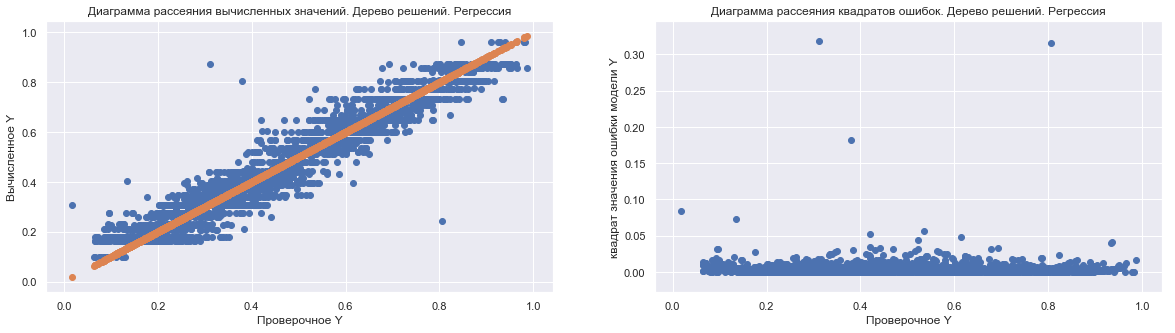

In [160]:
# Графики на одном полотне

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.scatter(y_test, y_treeRegr_d6)
plt.scatter(y_test, y_test)
plt.title(u'Диаграмма рассеяния вычисленных значений. Дерево решений. Регрессия');
plt.xlabel(u'Проверочное Y')
plt.ylabel(u'Вычисленное Y')

plt.subplot(122)
plt.scatter(y_test,  pow(abs(y_test - y_treeRegr_d6.reshape(-1,1)),2) )
plt.title(u'Диаграмма рассеяния квадратов ошибок. Дерево решений. Регрессия');
plt.xlabel(u'Проверочное Y')
plt.ylabel(u'квадрат значения ошибки модели Y')

Сохранение модели (Pickle)

In [162]:
import pickle
fileName_treeRegr_d6 = "model_treeRegr_d6.data_pickle"

with open(fileName_treeRegr_d6, 'wb') as f:
    pickle.dump(treeRegr_d6, f)
print "Модель {} сохнанена в файл \"{}\"".format(treeRegr_d6.__class__, fileName_treeRegr_d6)

Модель <class 'sklearn.tree.tree.DecisionTreeRegressor'> сохнанена в файл "model_treeRegr_d6.data_pickle"


Сохранение сопровождающей информации по моделям

In [163]:
dictModel_base['linear']   = dictModel_linear
dictModel_base['tree']     = dictModel_tree
dictModel_base['neuroNet2'] = dictModel_neuroNet2
dictModel_base['neuroNet12'] = dictModel_neuroNet12

json_filename   = 'model_description.json'

with open(json_filename, 'w') as outfile:
    json.dump(dictModel_base, outfile, indent=2)

# Вывод

Нейронная сеть
- MAE    0.052316 - средняя абсолютная ошибка.
- MSE    0.004336 - средреквадратичная ошибка.
- RMSE   0.065848 - кв. корень из средреквадратичной ошибки.
- R2     0.914973 - коэфф. детерминации.

Множественная линейная регрессия. Полный диапазон.
- y_pred_lin_reg_mult (x1, x2) =
   -0.793*Temperature + -0.244*Vacuum + 0.978

- MAE - Cредняя абсолютная ошибка:    0.05
- R2 - коэфф. детерминации:          0.918

Дерево решений. Регрессия. Усеченный диапазон.
- MAE - средняя абсолютная ошибка:   0.044 дерево регр. 
- R2  - коэфф. детерминации:         0.933 дерево регр.

Множественная линейная регрессия и дерево решений показали примерно одинаковый результат, нейронная сеть на их фоне работает чуть хуже.